<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

In [1]:
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
IBMQ.load_accounts()
%matplotlib inline

# Mapping virtual qubits in a circuit to physical qubits on a quantum device


In this tutorial we will see how to manually set the mapping from virtual circuit qubits to the physical qubits on a real quantum backend.  To begin, let us consider the following circuit that constructs a five qubit GHZ state:

In [2]:
qr = QuantumRegister(5,'qr')
cr = ClassicalRegister(5, 'cr')
ghz = QuantumCircuit(qr, cr, name='ghz')

ghz.h(qr[2])
ghz.cx(qr[2], qr[1])
ghz.cx(qr[1], qr[0])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.barrier(qr)
ghz.measure(qr, cr)
ghz.draw()

## Default circuit mapping via the transpiler

Let us use the transpiler to generate the circuit that is mapped onto the

In [3]:
device = IBMQ.get_backend('ibmq_16_melbourne')

device.

In [4]:
trans_ghz = transpile(ghz, device)

In [5]:
trans_ghz.draw()

We see that the output circuit has the gate set mapped to the first five qubits on the device (0->4).

To gauge the quality of this mapping, lets compute the depth of the output circuit.

In [6]:
trans_ghz.depth()

8

This depth is greater than that of the input

In [7]:
ghz.depth()

5

because the transpiler had to reverse some of the CNOT gates in the circuit to match the device topology (as seen below).

## Better results via manual mapping

It turns out that the GHZ circuit can be mapped exactly onto the Melbourne backend; the output circuit has the same depth as the input.  To do the mapping we just need to find which qubits to map to.  This is most easily done using the Jupyter magic function:

In [16]:
from qiskit.tools.jupyter import *
%qiskit_backend_monitor device

Upon inspection one can see that the GHZ circuit matches the topology provided that the circuit qubits are mapped to the device qubits using the following mapping: `0->10, 1->4, 2->5, 3->6, 4->8`.  Whats better, these qubits also have lower error rates, in both gates and measurements, than the qubits selected in the default mapping.

In qiskit we can express this mapping using a list:

In [9]:
layout = [10, 4, 5, 6, 8]

or equivilently using a dictionary that uses quantum register qubits as the keys, and device qubits as the corresponding values:

In [10]:
layout = {qr[0]: 10, qr[1]: 4, qr[2]: 5, qr[3]: 6, qr[4]: 8}

To use this mapping in the transpiler or in the `execute` function we can just set the layout as the `initial_layout` keyword argument to the functions:

In [11]:
trans_ghz_mapped = transpile(ghz, device, initial_layout=layout)

In [12]:
trans_ghz_mapped.draw()

In [13]:
trans_ghz_mapped.depth()

5

As we have verified, the returned circuit does exactly match the topology with the given layout.

## Running on the device

Lets now compare the performance of the circuits transpiled with the default and hand-selected layouts by running them on the device:

In [14]:
job = execute([trans_ghz, trans_ghz_mapped], device)
job_monitor(job)
res = job.result()

Job Status: job has successfully run


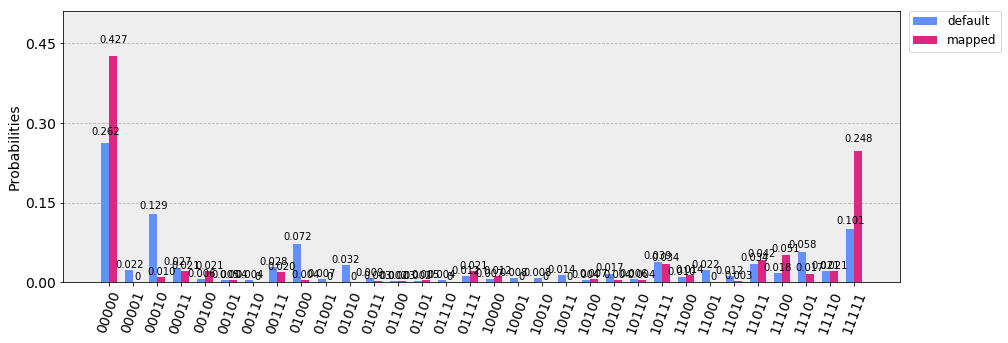

In [15]:
plot_histogram([res.get_counts(0), res.get_counts(1)],
               figsize=(15,5),
              legend=['default', 'mapped'])

It is clear that the circuits that we mapped to the ideal sub-graph of the device (red) give an answer that is much closer to the ideal distribution than those mapped in the default way.